In [4]:
%matplotlib widget

# Use: pip install ipywidgets ipympl
  
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add project path
project_root = Path("..").resolve()
sys.path.append(str(project_root))

from ml_toolbox.data_loader import DataLoader, WindowConfig, WindowExtractor

import scipy.signal as signal_proc
from scipy.signal import butter, filtfilt, medfilt
import pandas as pd

def design_butterworth_filter(cutoff_freq, sampling_freq, order=4):
    """
    Design Butterworth lowpass filter
    
    Parameters:
    - cutoff_freq: cutoff frequency in Hz
    - sampling_freq: sampling frequency in Hz
    - order: filter order
    """
    nyquist = sampling_freq / 2
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_zero_phase_filter(data, b, a):
    """
    Apply zero-phase filtering using filtfilt
    """
    return filtfilt(b, a, data)

def compute_fft_with_hann(signal, sampling_freq):
    """
    Compute FFT with Hann window for power spectral density estimation
    
    Parameters:
    - signal: input signal
    - sampling_freq: sampling frequency in Hz
    
    Returns:
    - freqs: frequency array
    - psd: power spectral density
    """
    # Apply Hann window
    windowed_signal = signal * np.hanning(len(signal))
    
    # Compute FFT
    fft_result = np.fft.fft(windowed_signal)
    
    # Calculate frequencies
    freqs = np.fft.fftfreq(len(signal), 1/sampling_freq)
    
    # Take only positive frequencies (one-sided spectrum)
    positive_freq_idx = freqs >= 0
    freqs = freqs[positive_freq_idx]
    fft_result = fft_result[positive_freq_idx]
    
    # Calculate power spectral density
    # Scale by 2 to account for negative frequencies (except DC and Nyquist)
    psd = np.abs(fft_result)**2 / (sampling_freq * len(signal))
    psd[1:-1] *= 2  # Scale all frequencies except DC and Nyquist
    
    # Correct for window power
    window_power = np.mean(np.hanning(len(signal))**2)
    psd /= window_power
    
    return freqs, psd


# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

# Signal processing parameters
sampling_freq = 10000  # 10 kHz
cutoff_freq = 3500     # 3.5 kHz cutoff
median_window = 15      # Median filter window

# Load one sample for demo
current_data, metadata = data_loader.load_batch(
    condition='system_misalignment', 
    load='no_load', 
    sensor_type='current', 
    frequency='30hz',
    apply_filter=False,
    max_workers=1
)

num_samples = current_data[0].shape[0] 
# Create windows
window_size = num_samples # All file
overlap_ratio = 0.5
step_size = int(window_size * (1 - overlap_ratio))
window_config = WindowConfig(window_size=window_size, 
                             step_size=step_size,
                             overlap_ratio=overlap_ratio)
extractor = WindowExtractor(window_config)
windows, win_metadata = extractor.extract_windows(current_data[0], metadata[0])
    
    
print(f"Loaded signal: {current_data[0].shape}")
print(f"Created {len(windows)} windows")

INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files


Loaded signal: (97749, 2)
Created 1 windows


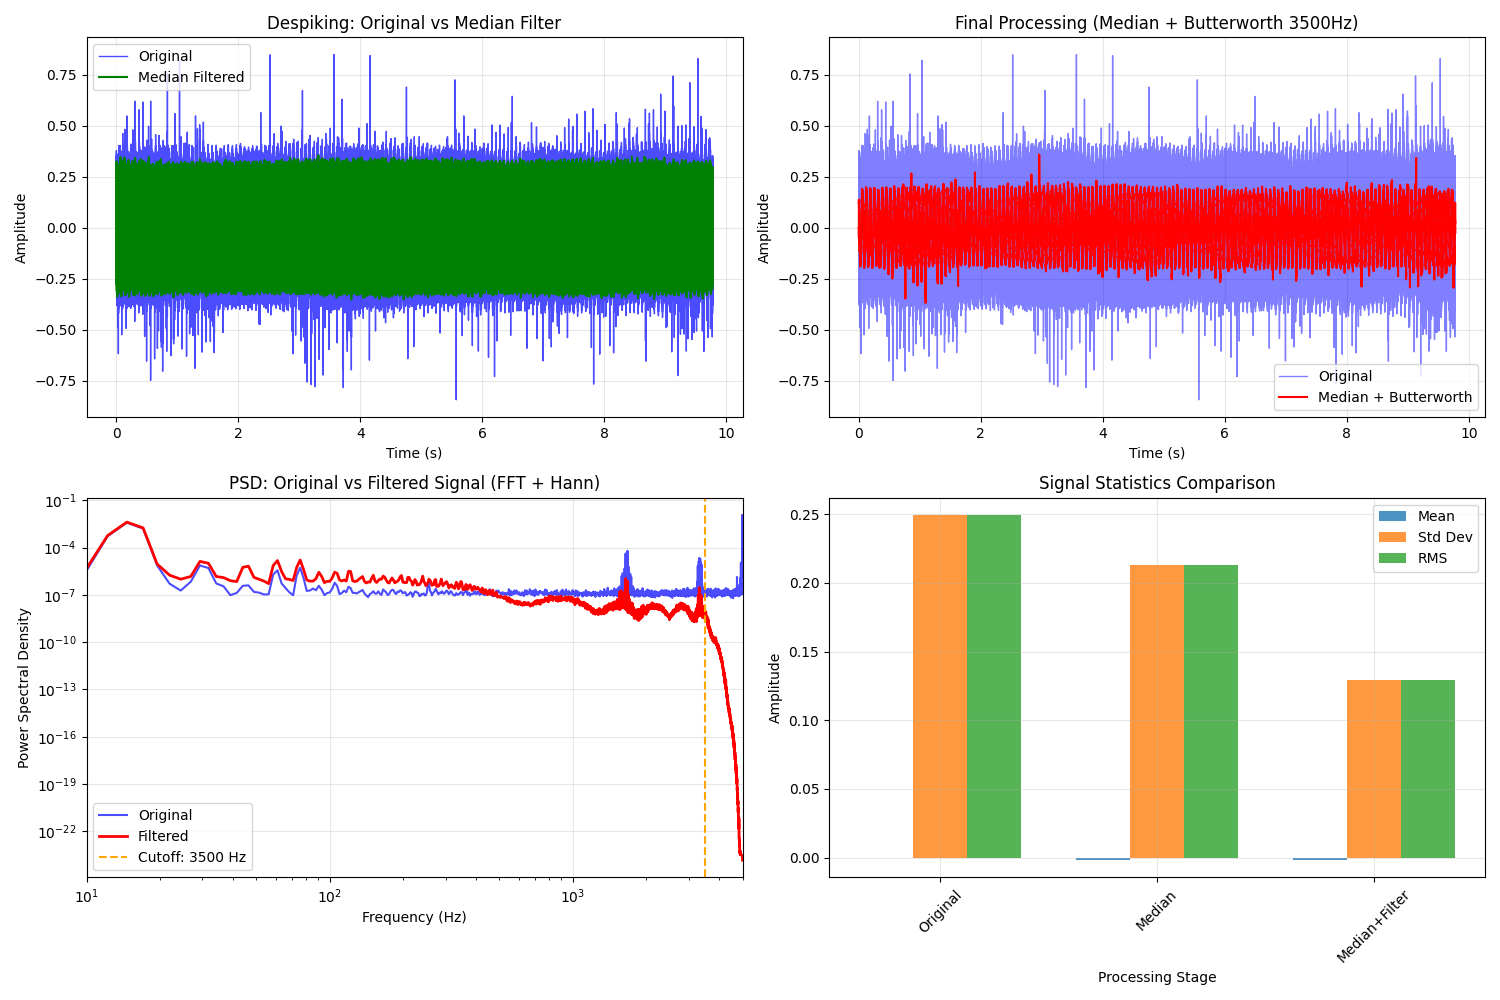

In [6]:
# Process the signal - apply despiking and filtering
window = windows[0]
original_signal = window[:, 0] if window.shape[1] > 0 else window

# Step 1: Apply median filter for despiking
median_filtered = medfilt(original_signal, kernel_size=median_window)

# Step 2: Design and apply Butterworth lowpass filter
b, a = design_butterworth_filter(cutoff_freq, sampling_freq, order=4)
filtered_signal = apply_zero_phase_filter(median_filtered, b, a)

# Create time vector
time = np.arange(len(original_signal)) / sampling_freq

# Interactive plot - compare original and processed signals
plt.ioff()  # Turn off interactive mode temporarily
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Original vs Median filtered
axes[0, 0].plot(time, original_signal, 'b-', linewidth=1, alpha=0.7, label='Original')
axes[0, 0].plot(time, median_filtered, 'g-', linewidth=1.5, label='Median Filtered')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Despiking: Original vs Median Filter')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Final processed signal (Median + Butterworth)
axes[0, 1].plot(time, original_signal, 'b-', linewidth=1, alpha=0.5, label='Original')
axes[0, 1].plot(time, filtered_signal, 'r-', linewidth=1.5, label='Median + Butterworth')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title(f'Final Processing (Median + Butterworth {cutoff_freq}Hz)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()


# Plot 3: Signal comparison in frequency domain
#from scipy.signal import welch
freqs_orig, psd_orig = signal_proc.welch(original_signal, fs=sampling_freq, nperseg=4096)
freqs_filt, psd_filtered = signal_proc.welch(filtered_signal, fs=sampling_freq, nperseg=4096)

# Plot 3: Signal comparison in frequency domain using FFT with Hann window
#freqs_orig, psd_orig = compute_fft_with_hann(original_signal, sampling_freq)
#freqs_filt, psd_filtered = compute_fft_with_hann(filtered_signal, sampling_freq)

axes[1, 0].loglog(freqs_orig, psd_orig, 'b-', alpha=0.7, label='Original')
axes[1, 0].loglog(freqs_filt, psd_filtered, 'r-', linewidth=2, label='Filtered')
axes[1, 0].axvline(cutoff_freq, color='orange', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Power Spectral Density')
axes[1, 0].set_title('PSD: Original vs Filtered Signal (FFT + Hann)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xlim(10, 5000)

# Plot 4: Signal statistics comparison
stats_data = {
    'Signal': ['Original', 'Median', 'Median+Filter'],
    'Mean': [np.mean(original_signal), np.mean(median_filtered), np.mean(filtered_signal)],
    'Std': [np.std(original_signal), np.std(median_filtered), np.std(filtered_signal)],
    'RMS': [np.sqrt(np.mean(original_signal**2)), np.sqrt(np.mean(median_filtered**2)), 
            np.sqrt(np.mean(filtered_signal**2))]
}

x_pos = np.arange(len(stats_data['Signal']))
width = 0.25
axes[1, 1].bar(x_pos - width, stats_data['Mean'], width, label='Mean', alpha=0.8)
axes[1, 1].bar(x_pos, stats_data['Std'], width, label='Std Dev', alpha=0.8)
axes[1, 1].bar(x_pos + width, stats_data['RMS'], width, label='RMS', alpha=0.8)
axes[1, 1].set_xlabel('Processing Stage')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].set_title('Signal Statistics Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(stats_data['Signal'], rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.ion()  # Turn interactive mode back on
plt.show()

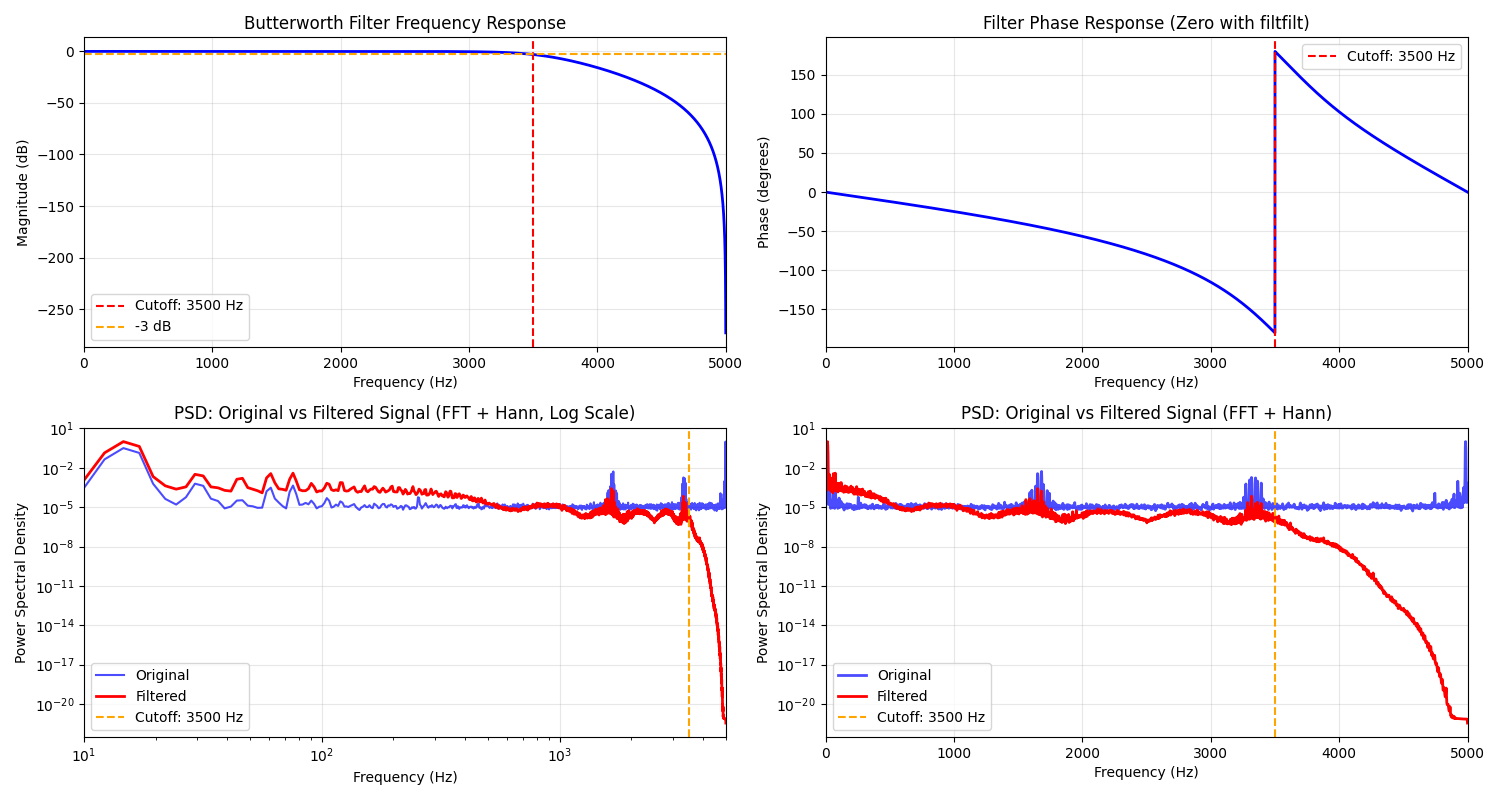


Signal Processing Summary (FFT with Hann Window):
Noise reduction: 48.3%


In [7]:
# Analyze filter characteristics and signal statistics
from scipy.signal import freqz

# Get filter frequency response
w, h = freqz(b, a, worN=8000, fs=sampling_freq)

# Normalize to [0, 1] so thresholds are comparable
psd_orig /= np.max(psd_orig)
psd_filtered /= np.max(psd_filtered)

plt.ioff()
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Plot 1: Filter frequency response
axes[0, 0].plot(w, 20 * np.log10(abs(h)), 'b-', linewidth=2)
axes[0, 0].axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[0, 0].axhline(-3, color='orange', linestyle='--', label='-3 dB')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Magnitude (dB)')
axes[0, 0].set_title('Butterworth Filter Frequency Response')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 5000)

# Plot 2: Phase response
axes[0, 1].plot(w, np.angle(h) * 180 / np.pi, 'b-', linewidth=2)
axes[0, 1].axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Phase (degrees)')
axes[0, 1].set_title('Filter Phase Response (Zero with filtfilt)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 5000)

# Plot 3: Power spectral density comparison (log-log scale)
axes[1, 0].loglog(freqs_orig, psd_orig, 'b-', alpha=0.7, label='Original')
axes[1, 0].loglog(freqs_filt, psd_filtered, 'r-', linewidth=2, label='Filtered')
axes[1, 0].axvline(cutoff_freq, color='orange', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Power Spectral Density')
axes[1, 0].set_title('PSD: Original vs Filtered Signal (FFT + Hann, Log Scale)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xlim(10, 5000)  # Start from 10 Hz to avoid log(0)

# Plot 4: Power spectral density comparison (logarithmic scale)
axes[1, 1].plot(freqs_orig, psd_orig, 'b-', alpha=0.7, label='Original', linewidth=2)
axes[1, 1].plot(freqs_filt, psd_filtered, 'r-', linewidth=2, label='Filtered')
axes[1, 1].axvline(cutoff_freq, color='orange', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Power Spectral Density')
axes[1, 1].set_title('PSD: Original vs Filtered Signal (FFT + Hann)')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 5000)

plt.tight_layout()
plt.ion()
plt.show()

# Print summary statistics
print("\nSignal Processing Summary (FFT with Hann Window):")
print("="*60)
print(f"Noise reduction: {((np.std(original_signal) - np.std(filtered_signal))/np.std(original_signal)*100):.1f}%")

In [8]:
# Power Spectral Density Analysis
from scipy.signal import find_peaks

# Original signal analysis
noise_floor_orig = np.median(psd_orig)
peaks_orig, _ = find_peaks(psd_orig, 
                           height=noise_floor_orig*3,   # threshold above baseline
                           prominence=noise_floor_orig*2,
                           distance=5)
#peaks_orig, _ = find_peaks(psd_orig, height=1e-3, prominence=1e-3, distance=5)  
dominant_freqs_orig = freqs_orig[peaks_orig]
dominant_powers_orig = psd_orig[peaks_orig]

# Filtered signal analysis
noise_floor_filt = np.median(psd_filtered)
peaks_filt, _ = find_peaks(psd_filtered, 
                           height=noise_floor_filt*3,   # threshold above baseline
                           prominence=noise_floor_filt*2,
                           distance=5)
#peaks_filt, _ = find_peaks(psd_filtered, height=1e-3, prominence=1e-3, distance=5)
dominant_freqs_filt = freqs_filt[peaks_filt]
dominant_powers_filt = psd_filtered[peaks_filt]

print(f"1. FREQUENCY DOMAIN STATISTICS:")
print("-" * 40)
print(f"Original Signal:")
print(f"  - Total Power: {np.trapezoid(psd_orig, freqs_orig):.2e}")
print(f"  - Peak Frequency: {freqs_orig[np.argmax(psd_orig)]:.1f} Hz")
print(f"  - Peak Power: {np.max(psd_orig):.2e}")
print(f"  - Dominant frequencies: {len(dominant_freqs_orig)} peaks")
if len(dominant_freqs_orig) > 0:
    for i, (freq, power) in enumerate(zip(dominant_freqs_orig, dominant_powers_orig)):
        print(f"    Peak {i+1}: {freq:.1f} Hz (Power: {power:.2e})")

print(f"\nFiltered Signal:")
print(f"  - Total Power: {np.trapezoid(psd_filtered, freqs_filt):.2e}")
print(f"  - Peak Frequency: {freqs_filt[np.argmax(psd_filtered)]:.1f} Hz") 
print(f"  - Peak Power: {np.max(psd_filtered):.2e}")
print(f"  - Dominant frequencies: {len(dominant_freqs_filt)} peaks")
if len(dominant_freqs_filt) > 0:
    for i, (freq, power) in enumerate(zip(dominant_freqs_filt, dominant_powers_filt)):
        print(f"    Peak {i+1}: {freq:.1f} Hz (Power: {power:.2e})")

# 2. Spectral Characteristics
print(f"\n2. SPECTRAL CHARACTERISTICS:")
print("-" * 40)

# Calculate spectral centroid (weighted average frequency)
def spectral_centroid(freqs, psd):
    return np.sum(freqs * psd) / np.sum(psd)

# Calculate spectral spread (frequency dispersion)
def spectral_spread(freqs, psd, centroid):
    return np.sqrt(np.sum(((freqs - centroid) ** 2) * psd) / np.sum(psd))

centroid_orig = spectral_centroid(freqs_orig, psd_orig)
centroid_filt = spectral_centroid(freqs_filt, psd_filtered)

spread_orig = spectral_spread(freqs_orig, psd_orig, centroid_orig)
spread_filt = spectral_spread(freqs_filt, psd_filtered, centroid_filt)

print(f"Spectral Centroid (weighted avg frequency):")
print(f"  Original: {centroid_orig:.1f} Hz")
print(f"  Filtered: {centroid_filt:.1f} Hz")

print(f"\nSpectral Spread (frequency dispersion):")
print(f"  Original: {spread_orig:.1f} Hz")
print(f"  Filtered: {spread_filt:.1f} Hz")

# 3. Frequency Band Energy Distribution
print(f"\n3. FREQUENCY BAND ENERGY DISTRIBUTION:")
print("-" * 40)

# Define frequency bands
bands = {
    'Very Low (0-100 Hz)': (0, 100),
    'Low (100-500 Hz)': (100, 500),
    'Mid (500-2000 Hz)': (500, 2000),
    'High (2000-3500 Hz)': (2000, 3500)
}

for band_name, (f_low, f_high) in bands.items():
    if f_high == np.inf:
        mask_orig = freqs_orig >= f_low
        mask_filt = freqs_filt >= f_low
    else:
        mask_orig = (freqs_orig >= f_low) & (freqs_orig <= f_high)
        mask_filt = (freqs_filt >= f_low) & (freqs_filt <= f_high)
    
    if np.any(mask_orig):
        energy_orig = np.trapezoid(psd_orig[mask_orig], freqs_orig[mask_orig])
        energy_filt = np.trapezoid(psd_filtered[mask_filt], freqs_filt[mask_filt])
        
        energy_percent_orig = (energy_orig / np.trapezoid(psd_orig, freqs_orig)) * 100
        energy_percent_filt = (energy_filt / np.trapezoid(psd_filtered, freqs_filt)) * 100
        
        print(f"{band_name}:")
        print(f"  Original: {energy_percent_orig:.1f}% of total energy")
        print(f"  Filtered: {energy_percent_filt:.1f}% of total energy")
        if energy_orig > 0:
            print(f"  Retention: {(energy_filt/energy_orig)*100:.1f}%")

print("\n" + "="*60)

1. FREQUENCY DOMAIN STATISTICS:
----------------------------------------
Original Signal:
  - Total Power: 5.20e+00
  - Peak Frequency: 4985.4 Hz
  - Peak Power: 1.00e+00
  - Dominant frequencies: 32 peaks
    Peak 1: 14.6 Hz (Power: 3.20e-01)
    Peak 2: 29.3 Hz (Power: 6.22e-04)
    Peak 3: 46.4 Hz (Power: 3.39e-05)
    Peak 4: 61.0 Hz (Power: 3.07e-04)
    Peak 5: 75.7 Hz (Power: 4.47e-04)
    Peak 6: 105.0 Hz (Power: 4.94e-05)
    Peak 7: 253.9 Hz (Power: 5.73e-05)
    Peak 8: 1591.8 Hz (Power: 1.33e-04)
    Peak 9: 1606.4 Hz (Power: 1.99e-04)
    Peak 10: 1635.7 Hz (Power: 4.05e-04)
    Peak 11: 1650.4 Hz (Power: 3.56e-03)
    Peak 12: 1682.1 Hz (Power: 5.27e-03)
    Peak 13: 1696.8 Hz (Power: 5.35e-04)
    Peak 14: 1726.1 Hz (Power: 1.83e-04)
    Peak 15: 1743.2 Hz (Power: 1.15e-04)
    Peak 16: 3256.8 Hz (Power: 5.83e-05)
    Peak 17: 3273.9 Hz (Power: 5.89e-04)
    Peak 18: 3303.2 Hz (Power: 1.21e-03)
    Peak 19: 3317.9 Hz (Power: 1.84e-03)
    Peak 20: 3349.6 Hz (Power: 1.69e

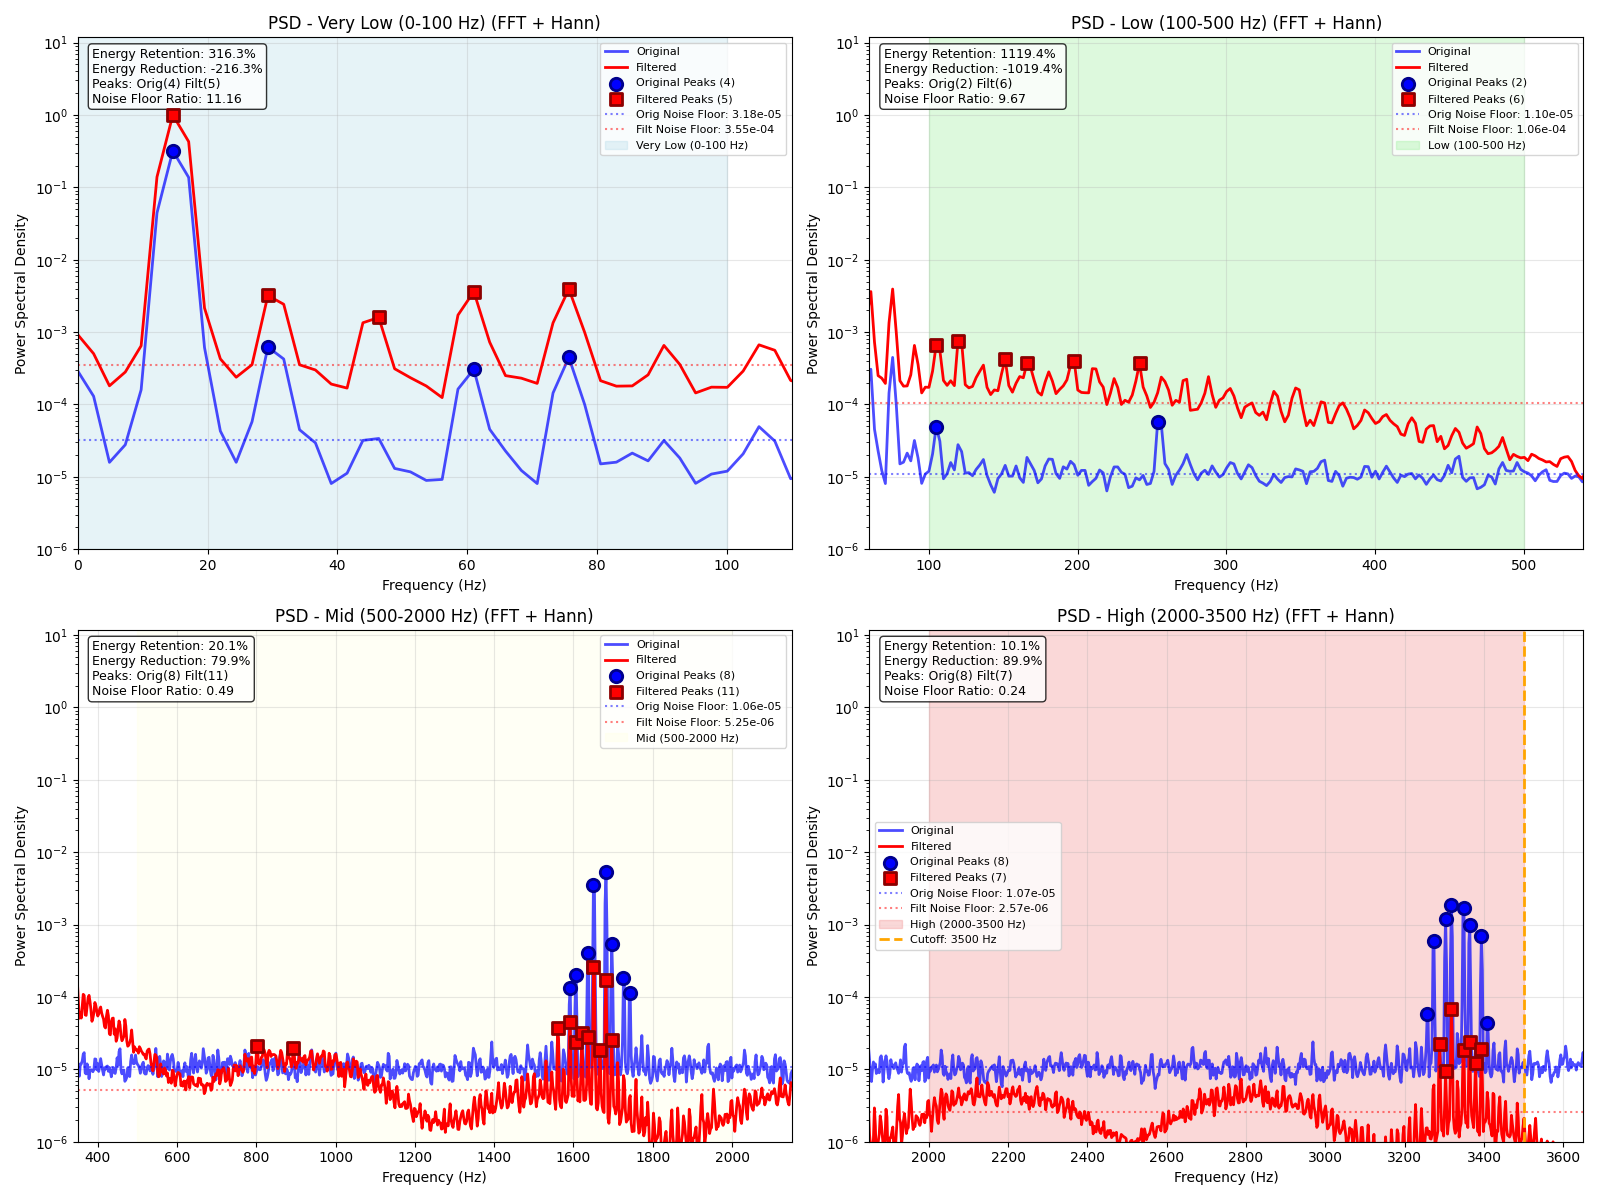


FREQUENCY BAND DETAILED PSD ANALYSIS (FFT with Hann Window)

Very Low (0-100 Hz) (0-100 Hz):
--------------------------------------------------
  Band-Specific Noise Floors:
    Original: 3.18e-05
    Filtered: 3.55e-04
    Ratio (Filt/Orig): 11.157
  Original Signal:
    Highest Peak: 14.6 Hz (Power: 3.20e-01)
    Average Power: 1.23e-02
    Total Energy: 1.23e+00
    Detected Peaks (band-specific): 4
    Peak Details:
      Peak 1: 14.6 Hz (Power: 3.20e-01, Prominence: 3.20e-01)
      Peak 2: 29.3 Hz (Power: 6.22e-04, Prominence: 6.06e-04)
      Peak 3: 61.0 Hz (Power: 3.07e-04, Prominence: 2.99e-04)
      Peak 4: 75.7 Hz (Power: 4.47e-04, Prominence: 4.39e-04)
  Filtered Signal:
    Highest Peak: 14.6 Hz (Power: 1.00e+00)
    Average Power: 3.90e-02
    Total Energy: 3.90e+00
    Detected Peaks (band-specific): 5
    Peak Details:
      Peak 1: 14.6 Hz (Power: 1.00e+00, Prominence: 1.00e+00)
      Peak 2: 29.3 Hz (Power: 3.20e-03, Prominence: 2.97e-03)
      Peak 3: 46.4 Hz (Power:

In [9]:
# PSD Plots by Individual Frequency Bands with Band-Specific Peak Detection
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

# Create 4 subplots - one for each frequency band
plt.ioff()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Make it easier to iterate

colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']

for i, (band_name, (f_low, f_high)) in enumerate(bands.items()):
    ax = axes[i]
    
    # Plot PSD for both original and filtered signals
    ax.plot(freqs_orig, psd_orig, 'b-', alpha=0.7, linewidth=2, label='Original')
    ax.plot(freqs_filt, psd_filtered, 'r-', linewidth=2, label='Filtered')
    
    # Create frequency masks for this band
    mask_orig = (freqs_orig >= f_low) & (freqs_orig <= f_high)
    mask_filt = (freqs_filt >= f_low) & (freqs_filt <= f_high)
    
    # Extract band-specific data
    if np.any(mask_orig):
        band_freqs_orig = freqs_orig[mask_orig]
        band_psd_orig = psd_orig[mask_orig]
        band_freqs_filt = freqs_filt[mask_filt]
        band_psd_filt = psd_filtered[mask_filt]
        
        # Calculate band-specific noise floors (medians)
        band_noise_floor_orig = np.median(band_psd_orig)
        band_noise_floor_filt = np.median(band_psd_filt)
        
        # Find peaks using band-specific thresholds
        band_peaks_orig_idx, _ = find_peaks(band_psd_orig, 
                                           height=band_noise_floor_orig*3,   # threshold above band baseline
                                           prominence=band_noise_floor_orig*2,
                                           distance=3)  # Reduced distance for band-specific detection
        
        band_peaks_filt_idx, _ = find_peaks(band_psd_filt, 
                                           height=band_noise_floor_filt*3,   # threshold above band baseline
                                           prominence=band_noise_floor_filt*2,
                                           distance=3)
        
        # Get actual frequencies and powers of detected peaks
        band_peaks_orig = band_freqs_orig[band_peaks_orig_idx]
        band_peaks_orig_powers = band_psd_orig[band_peaks_orig_idx]
        
        band_peaks_filt = band_freqs_filt[band_peaks_filt_idx]
        band_peaks_filt_powers = band_psd_filt[band_peaks_filt_idx]
        
        # Mark peaks on the plots
        if len(band_peaks_orig) > 0:
            ax.scatter(band_peaks_orig, band_peaks_orig_powers, color='blue', 
                      s=80, marker='o', edgecolors='darkblue', linewidths=2, 
                      label=f'Original Peaks ({len(band_peaks_orig)})', zorder=5)
        
        if len(band_peaks_filt) > 0:
            ax.scatter(band_peaks_filt, band_peaks_filt_powers, color='red', 
                      s=80, marker='s', edgecolors='darkred', linewidths=2, 
                      label=f'Filtered Peaks ({len(band_peaks_filt)})', zorder=5)
        
        # Add horizontal lines showing band-specific noise floors
        ax.axhline(band_noise_floor_orig, color='blue', linestyle=':', alpha=0.5, 
                  label=f'Orig Noise Floor: {band_noise_floor_orig:.2e}')
        ax.axhline(band_noise_floor_filt, color='red', linestyle=':', alpha=0.5, 
                  label=f'Filt Noise Floor: {band_noise_floor_filt:.2e}')
    else:
        band_peaks_orig = []
        band_peaks_filt = []
    
    # Highlight the current frequency band
    ax.axvspan(f_low, f_high, alpha=0.3, color=colors[i], 
               label=f'{band_name}')
    
    # Add vertical line for cutoff frequency if it's in this band
    if f_low <= cutoff_freq <= f_high:
        ax.axvline(cutoff_freq, color='orange', linestyle='--', linewidth=2, 
                   label=f'Cutoff: {cutoff_freq} Hz')
    
    # Set limits to focus on this frequency band with some padding
    padding = (f_high - f_low) * 0.1  # 10% padding
    ax.set_xlim(max(0, f_low - padding), f_high + padding)
    
    # Set y-axis to log scale for better visualization
    ax.set_yscale('log')
    ax.set_ylim(bottom=1e-6)
    
    # Labels and formatting
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title(f'PSD - {band_name} (FFT + Hann)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)  # Smaller font due to more labels
    
    # Calculate and display energy statistics for this band
    if np.any(mask_orig):
        energy_orig = np.trapezoid(band_psd_orig, band_freqs_orig)
        energy_filt = np.trapezoid(band_psd_filt, band_freqs_filt)
        
        if energy_orig > 0:
            retention = (energy_filt / energy_orig) * 100
            reduction = (1 - energy_filt/energy_orig) * 100
            
            # Add text box with statistics including peak counts and noise floors
            stats_text = (f'Energy Retention: {retention:.1f}%\n'
                         f'Energy Reduction: {reduction:.1f}%\n'
                         f'Peaks: Orig({len(band_peaks_orig)}) Filt({len(band_peaks_filt)})\n'
                         f'Noise Floor Ratio: {band_noise_floor_filt/band_noise_floor_orig:.2f}')
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', 
                   facecolor='white', alpha=0.8), fontsize=9)

plt.tight_layout()
plt.ion()
plt.show()

# Print detailed statistics for each band with band-specific peak detection
print("\n" + "="*80)
print("FREQUENCY BAND DETAILED PSD ANALYSIS (FFT with Hann Window)")
print("="*80)

for band_name, (f_low, f_high) in bands.items():
    print(f"\n{band_name} ({f_low}-{f_high} Hz):")
    print("-" * 50)
    
    # Create frequency masks
    mask_orig = (freqs_orig >= f_low) & (freqs_orig <= f_high)
    mask_filt = (freqs_filt >= f_low) & (freqs_filt <= f_high)
    
    if np.any(mask_orig):
        # Extract band data
        band_freqs_orig = freqs_orig[mask_orig]
        band_psd_orig = psd_orig[mask_orig]
        band_freqs_filt = freqs_filt[mask_filt]
        band_psd_filt = psd_filtered[mask_filt]
        
        # Calculate band-specific noise floors
        band_noise_floor_orig = np.median(band_psd_orig)
        band_noise_floor_filt = np.median(band_psd_filt)
        
        # Find peaks using band-specific thresholds
        band_peaks_orig_idx, peak_props_orig = find_peaks(band_psd_orig, 
                                                          height=band_noise_floor_orig*3,
                                                          prominence=band_noise_floor_orig*2,
                                                          distance=3)
        
        band_peaks_filt_idx, peak_props_filt = find_peaks(band_psd_filt, 
                                                          height=band_noise_floor_filt*3,
                                                          prominence=band_noise_floor_filt*2,
                                                          distance=3)
        
        # Overall peak analysis (highest peak in band)
        peak_idx_orig = np.argmax(band_psd_orig)
        peak_freq_orig = band_freqs_orig[peak_idx_orig]
        peak_power_orig = band_psd_orig[peak_idx_orig]
        
        peak_idx_filt = np.argmax(band_psd_filt)
        peak_freq_filt = band_freqs_filt[peak_idx_filt]
        peak_power_filt = band_psd_filt[peak_idx_filt]
        
        # Energy analysis
        energy_orig = np.trapezoid(band_psd_orig, band_freqs_orig)
        energy_filt = np.trapezoid(band_psd_filt, band_freqs_filt)
        
        # Statistics
        avg_power_orig = np.mean(band_psd_orig)
        avg_power_filt = np.mean(band_psd_filt)
        
        print(f"  Band-Specific Noise Floors:")
        print(f"    Original: {band_noise_floor_orig:.2e}")
        print(f"    Filtered: {band_noise_floor_filt:.2e}")
        print(f"    Ratio (Filt/Orig): {band_noise_floor_filt/band_noise_floor_orig:.3f}")
        
        print(f"  Original Signal:")
        print(f"    Highest Peak: {peak_freq_orig:.1f} Hz (Power: {peak_power_orig:.2e})")
        print(f"    Average Power: {avg_power_orig:.2e}")
        print(f"    Total Energy: {energy_orig:.2e}")
        print(f"    Detected Peaks (band-specific): {len(band_peaks_orig_idx)}")
        
        if len(band_peaks_orig_idx) > 0:
            print(f"    Peak Details:")
            for j, (peak_idx, freq, power) in enumerate(zip(band_peaks_orig_idx, 
                                                           band_freqs_orig[band_peaks_orig_idx], 
                                                           band_psd_orig[band_peaks_orig_idx])):
                prominence = peak_props_orig['prominences'][j] if 'prominences' in peak_props_orig else 0
                print(f"      Peak {j+1}: {freq:.1f} Hz (Power: {power:.2e}, Prominence: {prominence:.2e})")
        
        print(f"  Filtered Signal:")
        print(f"    Highest Peak: {peak_freq_filt:.1f} Hz (Power: {peak_power_filt:.2e})")
        print(f"    Average Power: {avg_power_filt:.2e}")
        print(f"    Total Energy: {energy_filt:.2e}")
        print(f"    Detected Peaks (band-specific): {len(band_peaks_filt_idx)}")
        
        if len(band_peaks_filt_idx) > 0:
            print(f"    Peak Details:")
            for j, (peak_idx, freq, power) in enumerate(zip(band_peaks_filt_idx, 
                                                           band_freqs_filt[band_peaks_filt_idx], 
                                                           band_psd_filt[band_peaks_filt_idx])):
                prominence = peak_props_filt['prominences'][j] if 'prominences' in peak_props_filt else 0
                print(f"      Peak {j+1}: {freq:.1f} Hz (Power: {power:.2e}, Prominence: {prominence:.2e})")
        
        print(f"  Filter Effect:")
        if energy_orig > 0:
            retention = (energy_filt / energy_orig) * 100
            reduction = (1 - energy_filt/energy_orig) * 100
            print(f"    Energy Retention: {retention:.1f}%")
            print(f"    Energy Reduction: {reduction:.1f}%")
        
        if avg_power_orig > 0:
            avg_power_reduction = (1 - avg_power_filt/avg_power_orig) * 100
            print(f"    Average Power Reduction: {avg_power_reduction:.1f}%")
        
        if peak_power_orig > 0:
            peak_power_reduction = (1 - peak_power_filt/peak_power_orig) * 100
            print(f"    Peak Power Reduction: {peak_power_reduction:.1f}%")
            
        print(f"    Peak Count Change: {len(band_peaks_filt_idx) - len(band_peaks_orig_idx)}")
        print(f"    Noise Floor Change: {((band_noise_floor_filt - band_noise_floor_orig)/band_noise_floor_orig)*100:.1f}%")
    else:
        print(f"  No data in this frequency range")

print("\n" + "="*70)

INFO:ml_toolbox.data_loader.data_loader:Loading 11 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 11 files
INFO:ml_toolbox.data_loader.data_loader:Loading 12 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files
INFO:ml_toolbox.data_loader.data_loader:Loading 12 files with 1 workers


Loading all data and grouping by frequency...
Loading: healthy - no_load
Loading: faulty bearing - no_load
Loading: misalignment - no_load


INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files
INFO:ml_toolbox.data_loader.data_loader:Loading 12 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 12 files


Loading: system misalignment - no_load
Found 4 frequency groups: ['10hz', '20hz', '30hz', '40hz']

Processing frequency 10hzHz (12 files)
  Processing file 1/12: healthy - test_LTR11_5R813982.dat
Page 1 added: Time domain - healthy - no_load - File 1
Error processing file 1 in 10hzHz group: name 'welch' is not defined
  Processing file 2/12: healthy - test_LTR11_5R813982.dat
Page 2 added: Time domain - healthy - no_load - File 2
Error processing file 2 in 10hzHz group: name 'welch' is not defined
  Processing file 3/12: healthy - test_LTR11_5R813982.dat
Page 3 added: Time domain - healthy - no_load - File 3
Error processing file 3 in 10hzHz group: name 'welch' is not defined
  Processing file 4/12: faulty bearing - test_LTR11_5R813982.dat
Page 4 added: Time domain - faulty bearing - no_load - File 4
Error processing file 4 in 10hzHz group: name 'welch' is not defined
  Processing file 5/12: faulty bearing - test_LTR11_5R813982.dat
Page 5 added: Time domain - faulty bearing - no_load - 

KeyboardInterrupt: 

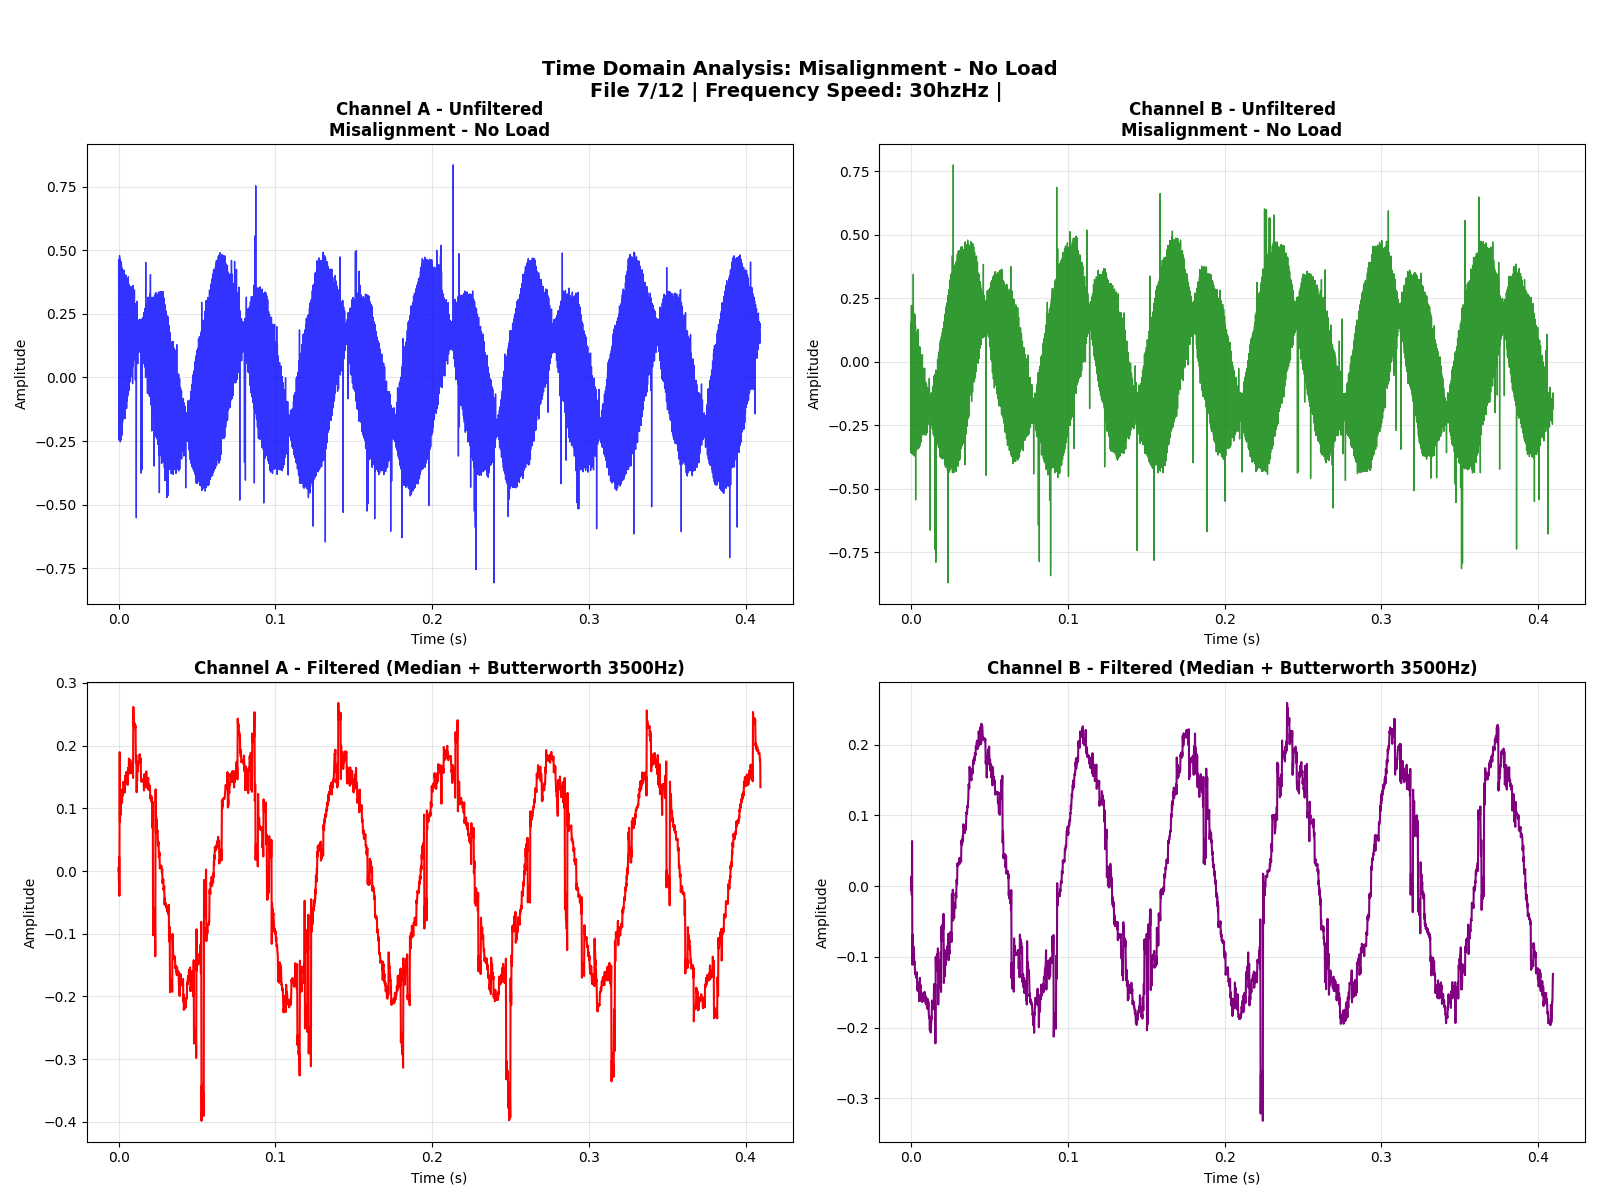

In [10]:
# Generate comprehensive PDF report for all datasets
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy.signal import find_peaks

def process_and_plot_all_datasets():
    """
    Process all datasets and create separate PDF files for each condition with:
    Page 1: 4 time domain plots per file:
    - Top left: Channel A unfiltered
    - Top right: Channel B unfiltered  
    - Bottom left: Channel A filtered
    - Bottom right: Channel B filtered
    
    Page 2: 4 frequency domain plots per file with peak detection:
    - Top left: Channel A PSD (Very Low & Low bands)
    - Top right: Channel A PSD (Mid & High bands)  
    - Bottom left: Channel B PSD (Very Low & Low bands)
    - Bottom right: Channel B PSD (Mid & High bands)
    """
    
    # All conditions and loads to process
    conditions = ['healthy', 'faulty bearing', 'misalignment', 'system misalignment']
    loads = ['no_load']  # Removed 'under_load' as requested
    
    # Use configuration from cell 2
    dataset_path = Path("../data_set")
    data_loader = DataLoader(dataset_path)
    
    # Store all generated PDF filenames
    generated_pdfs = []
      
    # First, collect all data and group by frequency
    print("Loading all data and grouping by frequency...")
    frequency_groups = {}
    
    for condition in conditions:
        for load in loads:
            try:
                print(f"Loading: {condition} - {load}")
                
                # Load current data
                current_data, metadata = data_loader.load_batch(
                    condition=condition,
                    load=load,
                    sensor_type='current',
                    max_workers=1
                )
                
                if not current_data:
                    print(f"No data found for {condition} - {load}")
                    continue
                
                # Group files by frequency
                for signal_data, signal_metadata in zip(current_data, metadata):
                    freq_speed = signal_metadata.get('frequency', 'Unknown')
                    
                    if freq_speed not in frequency_groups:
                        frequency_groups[freq_speed] = []
                    
                    frequency_groups[freq_speed].append({
                        'signal_data': signal_data,
                        'signal_metadata': signal_metadata,
                        'condition': condition,
                        'load': load
                    })
                    
            except Exception as e:
                print(f"Error loading {condition} - {load}: {str(e)}")
                continue
    
    print(f"Found {len(frequency_groups)} frequency groups: {list(frequency_groups.keys())}")
    
    # Process each frequency group separately
    for freq_speed in sorted(frequency_groups.keys()):
        # Create separate PDF for each frequency
        pdf_filename = f"../reports/frequency_{freq_speed}Hz_analysis.pdf"
        generated_pdfs.append(pdf_filename)
        
        with PdfPages(pdf_filename) as pdf:
            page_count = 0
            files_in_group = frequency_groups[freq_speed]
            
            print(f"\nProcessing frequency {freq_speed}Hz ({len(files_in_group)} files)")
            
            # Process all files for this frequency
            for file_idx, file_data in enumerate(files_in_group):
                signal_data = file_data['signal_data']
                signal_metadata = file_data['signal_metadata']
                condition = file_data['condition']
                load = file_data['load']
                
                try:
                    print(f"  Processing file {file_idx + 1}/{len(files_in_group)}: {condition} - {signal_metadata.get('filename', 'Unknown')}")
                    
                    # Create windows using same config as cell 2
                    num_samples = signal_data.shape[0]
                    window_size = 4096  # All file
                    overlap_ratio = 0.5
                    step_size = int(window_size * (1 - overlap_ratio))
                    window_config = WindowConfig(window_size=window_size, 
                                               step_size=step_size,
                                               overlap_ratio=overlap_ratio)
                    extractor = WindowExtractor(window_config)
                    windows, win_metadata = extractor.extract_windows(signal_data, signal_metadata)
                    
                    # Process first window
                    window = windows[0]
                    
                    # Extract channels A and B
                    if window.shape[1] >= 2:
                        channel_a = window[:, 0]
                        channel_b = window[:, 1]
                    else:
                        # If only one channel, duplicate it
                        channel_a = window[:, 0] if window.shape[1] > 0 else window.flatten()
                        channel_b = channel_a.copy()
                    
                    # Apply filtering to both channels using median filter
                    # Channel A processing
                    median_filtered_a = medfilt(channel_a, kernel_size=median_window)
                    filtered_a = apply_zero_phase_filter(median_filtered_a, b, a)
                    
                    # Channel B processing  
                    median_filtered_b = medfilt(channel_b, kernel_size=median_window)
                    filtered_b = apply_zero_phase_filter(median_filtered_b, b, a)
                    
                    # Create time vector
                    time = np.arange(len(channel_a)) / sampling_freq
                    
                    # Create the 4-subplot figure for time domain
                    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
                    
                    # Plot 1: Channel A unfiltered
                    axes[0, 0].plot(time, channel_a, 'b-', linewidth=1, alpha=0.8)
                    axes[0, 0].set_title(f'Channel A - Unfiltered\n{condition.title()} - {load.replace("_", " ").title()}', 
                                        fontsize=12, fontweight='bold')
                    axes[0, 0].set_xlabel('Time (s)')
                    axes[0, 0].set_ylabel('Amplitude')
                    axes[0, 0].grid(True, alpha=0.3)
                    
                    # Plot 2: Channel B unfiltered
                    axes[0, 1].plot(time, channel_b, 'g-', linewidth=1, alpha=0.8)
                    axes[0, 1].set_title(f'Channel B - Unfiltered\n{condition.title()} - {load.replace("_", " ").title()}', 
                                        fontsize=12, fontweight='bold')
                    axes[0, 1].set_xlabel('Time (s)')
                    axes[0, 1].set_ylabel('Amplitude')
                    axes[0, 1].grid(True, alpha=0.3)
                    
                    # Plot 3: Channel A filtered (only filtered signal)
                    axes[1, 0].plot(time, filtered_a, 'r-', linewidth=1.5)
                    axes[1, 0].set_title(f'Channel A - Filtered (Median + Butterworth {cutoff_freq}Hz)', 
                                        fontsize=12, fontweight='bold')
                    axes[1, 0].set_xlabel('Time (s)')
                    axes[1, 0].set_ylabel('Amplitude')
                    axes[1, 0].grid(True, alpha=0.3)
                    
                    # Plot 4: Channel B filtered (only filtered signal)
                    axes[1, 1].plot(time, filtered_b, 'purple', linewidth=1.5)
                    axes[1, 1].set_title(f'Channel B - Filtered (Median + Butterworth {cutoff_freq}Hz)', 
                                        fontsize=12, fontweight='bold')
                    axes[1, 1].set_xlabel('Time (s)')
                    axes[1, 1].set_ylabel('Amplitude')
                    axes[1, 1].grid(True, alpha=0.3)
                    
                    # Add overall figure title with frequency speed from metadata
                    fig.suptitle(f'Time Domain Analysis: {condition.title()} - {load.replace("_", " ").title()}\n'
                               f'File {file_idx+1}/{len(files_in_group)} | Frequency Speed: {freq_speed}Hz | ', 
                               fontsize=14, fontweight='bold', y=0.95)
                    
                    plt.tight_layout()
                    plt.subplots_adjust(top=0.88)  # Make room for suptitle
                    
                    # Save time domain page to PDF
                    pdf.savefig(fig, dpi=150, bbox_inches='tight')
                    plt.close(fig)  # Free memory
                    
                    page_count += 1
                    print(f"Page {page_count} added: Time domain - {condition} - {load} - File {file_idx+1}")
                        
                    
                    # === FREQUENCY DOMAIN ANALYSIS PAGE ===
                    
                    # Calculate PSD for both channels using FFT with Hann window
                    freqs_orig_a, psd_orig_a = welch(channel_a, fs=sampling_freq, nperseg=2048)
                    freqs_filt_a, psd_filt_a = welch(filtered_a, fs=sampling_freq, nperseg=2048)
                    freqs_orig_b, psd_orig_b = welch(channel_b, fs=sampling_freq, nperseg=2048)
                    freqs_filt_b, psd_filt_b = welch(filtered_b, fs=sampling_freq, nperseg=2048)
                    
                    # Normalize PSDs to [0, 1] for consistent peak detection
                    psd_orig_a_norm = psd_orig_a / np.max(psd_orig_a)
                    psd_filt_a_norm = psd_filt_a / np.max(psd_filt_a)
                    psd_orig_b_norm = psd_orig_b / np.max(psd_orig_b)
                    psd_filt_b_norm = psd_filt_b / np.max(psd_filt_b)
                    
                    # Create frequency domain figure
                    fig_freq, axes_freq = plt.subplots(2, 2, figsize=(16, 12))
                    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
                    
                    # Function to plot frequency band with peak detection
                    def plot_frequency_band(ax, freqs_orig, psd_orig, freqs_filt, psd_filt, 
                                          psd_orig_norm, psd_filt_norm, band_name, f_low, f_high, color, channel_name):
                        
                        # Plot PSD for both original and filtered signals
                        ax.plot(freqs_orig, psd_orig, 'b-', alpha=0.7, linewidth=2, label='Original')
                        ax.plot(freqs_filt, psd_filt, 'r-', linewidth=2, label='Filtered')
                        
                        # Create frequency masks for this band
                        mask_orig = (freqs_orig >= f_low) & (freqs_orig <= f_high)
                        mask_filt = (freqs_filt >= f_low) & (freqs_filt <= f_high)
                        
                        # Extract band-specific data
                        if np.any(mask_orig):
                            band_freqs_orig = freqs_orig[mask_orig]
                            band_psd_orig_norm = psd_orig_norm[mask_orig]
                            band_freqs_filt = freqs_filt[mask_filt]
                            band_psd_filt_norm = psd_filt_norm[mask_filt]
                            
                            # Calculate band-specific noise floors (medians)
                            band_noise_floor_orig = np.median(band_psd_orig_norm)
                            band_noise_floor_filt = np.median(band_psd_filt_norm)
                            
                            # Find peaks using band-specific thresholds
                            band_peaks_orig_idx, _ = find_peaks(band_psd_orig_norm, 
                                                               height=band_noise_floor_orig*3,
                                                               prominence=band_noise_floor_orig*2,
                                                               distance=3)
                            
                            band_peaks_filt_idx, _ = find_peaks(band_psd_filt_norm, 
                                                               height=band_noise_floor_filt*3,
                                                               prominence=band_noise_floor_filt*2,
                                                               distance=3)
                            
                            # Get actual frequencies and powers of detected peaks (original scale)
                            if len(band_peaks_orig_idx) > 0:
                                band_peaks_orig = band_freqs_orig[band_peaks_orig_idx]
                                band_peaks_orig_powers = psd_orig[mask_orig][band_peaks_orig_idx]
                                ax.scatter(band_peaks_orig, band_peaks_orig_powers, color='blue', 
                                          s=60, marker='o', edgecolors='darkblue', linewidths=2, 
                                          label=f'Original Peaks ({len(band_peaks_orig)})', zorder=5)
                            
                            if len(band_peaks_filt_idx) > 0:
                                band_peaks_filt = band_freqs_filt[band_peaks_filt_idx]
                                band_peaks_filt_powers = psd_filt[mask_filt][band_peaks_filt_idx]
                                ax.scatter(band_peaks_filt, band_peaks_filt_powers, color='red', 
                                          s=60, marker='s', edgecolors='darkred', linewidths=2, 
                                          label=f'Filtered Peaks ({len(band_peaks_filt)})', zorder=5)
                            
                            # Add text box with peak statistics only
                            stats_text = f'Peaks: Orig({len(band_peaks_orig_idx)}) Filt({len(band_peaks_filt_idx)})'
                            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                                   verticalalignment='top', bbox=dict(boxstyle='round', 
                                   facecolor='white', alpha=0.8), fontsize=9)
                        
                        # Highlight the current frequency band
                        ax.axvspan(f_low, f_high, alpha=0.3, color=color, label=f'{band_name}')
                        
                        # Add vertical line for cutoff frequency if it's in this band
                        if f_low <= cutoff_freq <= f_high:
                            ax.axvline(cutoff_freq, color='orange', linestyle='--', linewidth=2, 
                                       label=f'Cutoff: {cutoff_freq} Hz')
                        
                        # Set limits to focus on this frequency band with some padding
                        padding = (f_high - f_low) * 0.1
                        ax.set_xlim(max(0, f_low - padding), f_high + padding)
                        
                        # Set y-axis to log scale for better visualization
                        ax.set_yscale('log')
                        ax.set_ylim(bottom=1e-10)
                        
                        # Labels and formatting
                        ax.set_xlabel('Frequency (Hz)')
                        ax.set_ylabel('Power Spectral Density')
                        ax.set_title(f'{channel_name} PSD - {band_name}', fontsize=11, fontweight='bold')
                        ax.grid(True, alpha=0.3)
                        ax.legend(fontsize=8)
                    
                    # Plot frequency bands for Channel A
                    # Top left: Channel A - Very Low & Low bands combined
                    plot_frequency_band(axes_freq[0, 0], freqs_orig_a, psd_orig_a, freqs_filt_a, psd_filt_a,
                                      psd_orig_a_norm, psd_filt_a_norm, "Very Low & Low", 0, 500, 'lightblue', 'Channel A')
                    
                    # Top right: Channel A - Mid & High bands combined  
                    plot_frequency_band(axes_freq[0, 1], freqs_orig_a, psd_orig_a, freqs_filt_a, psd_filt_a,
                                      psd_orig_a_norm, psd_filt_a_norm, "Mid & High", 500, 3500, 'lightgreen', 'Channel A')
                    
                    # Bottom left: Channel B - Very Low & Low bands combined
                    plot_frequency_band(axes_freq[1, 0], freqs_orig_b, psd_orig_b, freqs_filt_b, psd_filt_b,
                                      psd_orig_b_norm, psd_filt_b_norm, "Very Low & Low", 0, 500, 'lightyellow', 'Channel B')
                    
                    # Bottom right: Channel B - Mid & High bands combined
                    plot_frequency_band(axes_freq[1, 1], freqs_orig_b, psd_orig_b, freqs_filt_b, psd_filt_b,
                                      psd_orig_b_norm, psd_filt_b_norm, "Mid & High", 500, 3500, 'lightcoral', 'Channel B')
                    
                    # Add overall figure title for frequency domain
                    fig_freq.suptitle(f'Frequency Domain Analysis: {condition.title()} - {load.replace("_", " ").title()}\n'
                                    f'File {file_idx+1}/{len(files_in_group)} | Frequency Speed: {freq_speed}Hz | '
                                    f'FFT with Hann Window Peak Detection', 
                                    fontsize=14, fontweight='bold', y=0.95)
                    
                    plt.tight_layout()
                    plt.subplots_adjust(top=0.88)  # Make room for suptitle
                    
                    # Save frequency domain page to PDF
                    pdf.savefig(fig_freq, dpi=150, bbox_inches='tight')
                    plt.close(fig_freq)  # Free memory
                    
                    page_count += 1
                    print(f"Page {page_count} added: Frequency domain - {condition} - {load} - File {file_idx+1}")
                except Exception as e:
                    print(f"Error processing file {file_idx+1} in {freq_speed}Hz group: {str(e)}")
                    continue
            
            print(f"\nPDF report generated: {pdf_filename}")
            print(f"Total pages: {page_count}")
    
    print(f"\nAll PDF reports generated:")
    for pdf_file in generated_pdfs:
        print(f"  - {pdf_file}")
    return generated_pdfs

# Execute the analysis
pdf_files = process_and_plot_all_datasets()

In [ ]:
# Compare Welch vs FFT methods for frequency resolution analysis
from scipy.signal import welch
import matplotlib.pyplot as plt

# Get the original signal for analysis
window = windows[0]
original_signal = window[:, 0] if window.shape[1] > 0 else window

print(f"Signal length: {len(original_signal)} samples")
print(f"Sampling frequency: {sampling_freq} Hz")
print(f"Signal duration: {len(original_signal)/sampling_freq:.3f} seconds")

# Calculate frequency resolution
freq_resolution_fft = sampling_freq / len(original_signal)
print(f"FFT frequency resolution: {freq_resolution_fft:.3f} Hz")

# Method 1: Welch's method
nperseg = 2048  # Segment length for Welch
noverlap = nperseg // 2  # 50% overlap
freqs_welch, psd_welch = welch(original_signal, fs=sampling_freq, 
                               nperseg=nperseg, noverlap=noverlap)

# Calculate frequency resolution for Welch
freq_resolution_welch = sampling_freq / nperseg
print(f"Welch frequency resolution: {freq_resolution_welch:.3f} Hz")

# Method 2: FFT with Hann window (your current method)
freqs_fft, psd_fft = compute_fft_with_hann(original_signal, sampling_freq)

# Method 3: FFT with zero-padding for better frequency resolution
zero_padded_length = len(original_signal) * 4  # 4x zero padding
padded_signal = np.zeros(zero_padded_length)
padded_signal[:len(original_signal)] = original_signal
freqs_fft_padded, psd_fft_padded = compute_fft_with_hann(padded_signal, sampling_freq)

freq_resolution_padded = sampling_freq / zero_padded_length
print(f"Zero-padded FFT frequency resolution: {freq_resolution_padded:.3f} Hz")

# Find peaks in low frequency range (0-50 Hz) for each method
low_freq_mask_welch = (freqs_welch >= 0) & (freqs_welch <= 50)
low_freq_mask_fft = (freqs_fft >= 0) & (freqs_fft <= 50)
low_freq_mask_padded = (freqs_fft_padded >= 0) & (freqs_fft_padded <= 50)

# Find the strongest peak in low frequency range
peak_idx_welch = np.argmax(psd_welch[low_freq_mask_welch])
peak_freq_welch = freqs_welch[low_freq_mask_welch][peak_idx_welch]
peak_power_welch = psd_welch[low_freq_mask_welch][peak_idx_welch]

peak_idx_fft = np.argmax(psd_fft[low_freq_mask_fft])
peak_freq_fft = freqs_fft[low_freq_mask_fft][peak_idx_fft]
peak_power_fft = psd_fft[low_freq_mask_fft][peak_idx_fft]

peak_idx_padded = np.argmax(psd_fft_padded[low_freq_mask_padded])
peak_freq_padded = freqs_fft_padded[low_freq_mask_padded][peak_idx_padded]
peak_power_padded = psd_fft_padded[low_freq_mask_padded][peak_idx_padded]

print(f"\nPeak Detection Results:")
print(f"Welch method: Peak at {peak_freq_welch:.2f} Hz (Power: {peak_power_welch:.2e})")
print(f"FFT method: Peak at {peak_freq_fft:.2f} Hz (Power: {peak_power_fft:.2e})")
print(f"Zero-padded FFT: Peak at {peak_freq_padded:.2f} Hz (Power: {peak_power_padded:.2e})")

# Plot comparison
plt.ioff()
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Full spectrum comparison (log scale)
axes[0, 0].loglog(freqs_welch, psd_welch, 'b-', linewidth=2, label='Welch', alpha=0.8)
axes[0, 0].loglog(freqs_fft, psd_fft, 'r-', linewidth=2, label='FFT + Hann', alpha=0.8)
axes[0, 0].loglog(freqs_fft_padded, psd_fft_padded, 'g-', linewidth=1, label='Zero-padded FFT', alpha=0.7)
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Power Spectral Density')
axes[0, 0].set_title('Full Spectrum Comparison (Log Scale)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xlim(1, 1000)

# Plot 2: Low frequency zoom (0-50 Hz) - Linear scale
axes[0, 1].plot(freqs_welch[low_freq_mask_welch], psd_welch[low_freq_mask_welch], 
                'b-', linewidth=2, label='Welch', marker='o', markersize=3)
axes[0, 1].plot(freqs_fft[low_freq_mask_fft], psd_fft[low_freq_mask_fft], 
                'r-', linewidth=2, label='FFT + Hann', marker='s', markersize=3)
axes[0, 1].plot(freqs_fft_padded[low_freq_mask_padded], psd_fft_padded[low_freq_mask_padded], 
                'g-', linewidth=1, label='Zero-padded FFT', marker='^', markersize=2)

# Mark the peaks
axes[0, 1].scatter(peak_freq_welch, peak_power_welch, color='blue', s=100, 
                   marker='o', edgecolors='darkblue', linewidths=2, label=f'Welch Peak: {peak_freq_welch:.2f} Hz')
axes[0, 1].scatter(peak_freq_fft, peak_power_fft, color='red', s=100, 
                   marker='s', edgecolors='darkred', linewidths=2, label=f'FFT Peak: {peak_freq_fft:.2f} Hz')
axes[0, 1].scatter(peak_freq_padded, peak_power_padded, color='green', s=100, 
                   marker='^', edgecolors='darkgreen', linewidths=2, label=f'Padded Peak: {peak_freq_padded:.2f} Hz')

# Add reference line at 10 Hz
axes[0, 1].axvline(10.0, color='orange', linestyle='--', linewidth=2, label='Expected: 10 Hz')

axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Power Spectral Density')
axes[0, 1].set_title('Low Frequency Detail (0-50 Hz)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=8)
axes[0, 1].set_xlim(0, 50)

# Plot 3: Very low frequency zoom (0-20 Hz) - Log scale
very_low_mask_welch = (freqs_welch >= 0) & (freqs_welch <= 20)
very_low_mask_fft = (freqs_fft >= 0) & (freqs_fft <= 20)
very_low_mask_padded = (freqs_fft_padded >= 0) & (freqs_fft_padded <= 20)

axes[1, 0].semilogy(freqs_welch[very_low_mask_welch], psd_welch[very_low_mask_welch], 
                    'b-', linewidth=2, label='Welch', marker='o', markersize=4)
axes[1, 0].semilogy(freqs_fft[very_low_mask_fft], psd_fft[very_low_mask_fft], 
                    'r-', linewidth=2, label='FFT + Hann', marker='s', markersize=4)
axes[1, 0].semilogy(freqs_fft_padded[very_low_mask_padded], psd_fft_padded[very_low_mask_padded], 
                    'g-', linewidth=1, label='Zero-padded FFT', marker='^', markersize=3)

# Mark the peaks again
axes[1, 0].scatter(peak_freq_welch, peak_power_welch, color='blue', s=120, 
                   marker='o', edgecolors='darkblue', linewidths=3, zorder=5)
axes[1, 0].scatter(peak_freq_fft, peak_power_fft, color='red', s=120, 
                   marker='s', edgecolors='darkred', linewidths=3, zorder=5)
axes[1, 0].scatter(peak_freq_padded, peak_power_padded, color='green', s=120, 
                   marker='^', edgecolors='darkgreen', linewidths=3, zorder=5)

axes[1, 0].axvline(10.0, color='orange', linestyle='--', linewidth=2, label='Expected: 10 Hz')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Power Spectral Density (Log Scale)')
axes[1, 0].set_title('Very Low Frequency Detail (0-20 Hz)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 20)

# Plot 4: Frequency resolution comparison
methods = ['Welch\n(nperseg=2048)', 'FFT\n(Original)', 'FFT\n(Zero-padded)']
resolutions = [freq_resolution_welch, freq_resolution_fft, freq_resolution_padded]
detected_freqs = [peak_freq_welch, peak_freq_fft, peak_freq_padded]
errors = [abs(f - 10.0) for f in detected_freqs]

x_pos = np.arange(len(methods))
bars1 = axes[1, 1].bar(x_pos - 0.2, resolutions, 0.4, label='Frequency Resolution (Hz)', alpha=0.7, color='skyblue')
bars2 = axes[1, 1].bar(x_pos + 0.2, errors, 0.4, label='Error from 10 Hz', alpha=0.7, color='lightcoral')

# Add value labels on bars
for i, (res, err, freq) in enumerate(zip(resolutions, errors, detected_freqs)):
    axes[1, 1].text(i - 0.2, res + 0.01, f'{res:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    axes[1, 1].text(i + 0.2, err + 0.01, f'{err:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    axes[1, 1].text(i, -0.15, f'Detected:\n{freq:.2f} Hz', ha='center', va='top', fontsize=8, 
                    transform=axes[1, 1].get_xaxis_transform())

axes[1, 1].set_xlabel('Method')
axes[1, 1].set_ylabel('Frequency (Hz)')
axes[1, 1].set_title('Frequency Resolution vs Detection Error')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(methods)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.ion()
plt.show()

print(f"\nAnalysis Summary:")
print(f"=" * 50)
print(f"Expected supply frequency: 10.0 Hz")
print(f"Welch detection error: {abs(peak_freq_welch - 10.0):.3f} Hz")
print(f"FFT detection error: {abs(peak_freq_fft - 10.0):.3f} Hz") 
print(f"Zero-padded FFT detection error: {abs(peak_freq_padded - 10.0):.3f} Hz")
print(f"\nThe frequency resolution determines how precisely we can detect peaks.")
print(f"Welch uses shorter segments (better resolution) while your FFT uses the full signal length.")

In [ ]:
# DIAGNOSTIC ANALYSIS: Why are we getting 5 Hz instead of 10 Hz?
# Let's investigate this systematically

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch, find_peaks

# Get the signal
window = windows[0]
original_signal = window[:, 0] if window.shape[1] > 0 else window

# First, let's examine the metadata more carefully
print("=== METADATA INVESTIGATION ===")
print(f"Signal metadata: {metadata[0]}")
print(f"Window metadata: {win_metadata[0] if win_metadata else 'None'}")
print(f"Signal shape: {original_signal.shape}")
print(f"Signal duration: {len(original_signal)/sampling_freq:.3f} seconds")
print(f"Expected frequency from metadata: {metadata[0].get('frequency', 'Unknown')}")

# Check basic signal statistics
print(f"\n=== SIGNAL STATISTICS ===")
print(f"Mean: {np.mean(original_signal):.6f}")
print(f"Std: {np.std(original_signal):.6f}")
print(f"Min: {np.min(original_signal):.6f}")
print(f"Max: {np.max(original_signal):.6f}")
print(f"Peak-to-peak: {np.ptp(original_signal):.6f}")

# Look for periodicity by examining autocorrelation
print(f"\n=== PERIODICITY ANALYSIS ===")
# Autocorrelation to find period
autocorr = np.correlate(original_signal - np.mean(original_signal), 
                       original_signal - np.mean(original_signal), mode='full')
autocorr = autocorr[autocorr.size // 2:]  # Take only positive lags
autocorr = autocorr / autocorr[0]  # Normalize

# Find peaks in autocorrelation (these indicate periods)
autocorr_peaks, _ = find_peaks(autocorr[1:], height=0.1, distance=50)  # Skip the first peak (lag=0)
autocorr_peaks += 1  # Adjust for skipping first element

if len(autocorr_peaks) > 0:
    # Convert lag to frequency
    periods_samples = autocorr_peaks[:5]  # Take first 5 periods
    periods_seconds = periods_samples / sampling_freq
    frequencies_from_autocorr = 1.0 / periods_seconds
    
    print(f"Autocorrelation peak lags (samples): {periods_samples}")
    print(f"Corresponding periods (seconds): {periods_seconds}")
    print(f"Corresponding frequencies (Hz): {frequencies_from_autocorr}")
else:
    print("No clear periodic peaks found in autocorrelation")

# Now let's do a more detailed frequency analysis
print(f"\n=== DETAILED FREQUENCY ANALYSIS ===")

# Method 1: Very high resolution FFT (zero-padded)
N_original = len(original_signal)
N_padded = N_original * 8  # 8x zero padding for high resolution
padded_signal = np.zeros(N_padded)
padded_signal[:N_original] = original_signal - np.mean(original_signal)  # Remove DC

# Apply window and FFT
windowed = padded_signal * np.hanning(N_padded)
fft_result = np.fft.fft(windowed)
freqs_high_res = np.fft.fftfreq(N_padded, 1/sampling_freq)

# Take positive frequencies only
pos_mask = freqs_high_res >= 0
freqs_high_res = freqs_high_res[pos_mask]
psd_high_res = np.abs(fft_result[pos_mask])**2

# Focus on low frequencies (0-50 Hz)
low_freq_mask = (freqs_high_res >= 0.1) & (freqs_high_res <= 50)
freqs_low = freqs_high_res[low_freq_mask]
psd_low = psd_high_res[low_freq_mask]

# Find all significant peaks in low frequency range
peak_threshold = np.max(psd_low) * 0.01  # 1% of maximum
peaks_idx, peak_properties = find_peaks(psd_low, height=peak_threshold, distance=5)

peak_freqs = freqs_low[peaks_idx]
peak_powers = psd_low[peaks_idx]

# Sort by power (strongest first)
sorted_indices = np.argsort(peak_powers)[::-1]
peak_freqs_sorted = peak_freqs[sorted_indices]
peak_powers_sorted = peak_powers[sorted_indices]

print(f"High-resolution FFT frequency resolution: {freqs_high_res[1] - freqs_high_res[0]:.4f} Hz")
print(f"Found {len(peak_freqs)} significant peaks in 0-50 Hz range:")
for i, (freq, power) in enumerate(zip(peak_freqs_sorted[:10], peak_powers_sorted[:10])):  # Top 10 peaks
    print(f"  Peak {i+1}: {freq:.3f} Hz (Relative power: {power/np.max(psd_low):.3f})")

# Check if we have harmonics
print(f"\n=== HARMONIC ANALYSIS ===")
if len(peak_freqs_sorted) > 0:
    fundamental = peak_freqs_sorted[0]
    print(f"Strongest peak (potential fundamental): {fundamental:.3f} Hz")
    
    # Look for harmonics (multiples of the fundamental)
    harmonics_found = []
    for i, freq in enumerate(peak_freqs_sorted):
        harmonic_ratio = freq / fundamental
        if abs(harmonic_ratio - round(harmonic_ratio)) < 0.1:  # Within 10% of integer multiple
            harmonics_found.append((freq, round(harmonic_ratio), peak_powers_sorted[i]/np.max(psd_low)))
    
    print(f"Potential harmonics of {fundamental:.3f} Hz:")
    for freq, harmonic_num, relative_power in harmonics_found:
        print(f"  {harmonic_num}x: {freq:.3f} Hz (Relative power: {relative_power:.3f})")

# Check if 10 Hz is present but weaker
ten_hz_region = (freqs_low >= 9.5) & (freqs_low <= 10.5)
if np.any(ten_hz_region):
    ten_hz_freqs = freqs_low[ten_hz_region]
    ten_hz_psd = psd_low[ten_hz_region]
    max_ten_hz_idx = np.argmax(ten_hz_psd)
    max_ten_hz_freq = ten_hz_freqs[max_ten_hz_idx]
    max_ten_hz_power = ten_hz_psd[max_ten_hz_idx]
    
    print(f"\n=== 10 Hz REGION ANALYSIS ===")
    print(f"Strongest peak near 10 Hz: {max_ten_hz_freq:.3f} Hz")
    print(f"Relative power: {max_ten_hz_power/np.max(psd_low):.3f}")
    print(f"Ratio to strongest overall peak: {max_ten_hz_power/peak_powers_sorted[0]:.3f}")

# Plot the detailed analysis
plt.ioff()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Time domain signal
time = np.arange(len(original_signal)) / sampling_freq
axes[0, 0].plot(time, original_signal, 'b-', linewidth=1)
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Original Signal (Time Domain)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Autocorrelation
lags = np.arange(len(autocorr)) / sampling_freq
axes[0, 1].plot(lags[:2000], autocorr[:2000], 'g-', linewidth=1)  # Show first 2000 lags
if len(autocorr_peaks) > 0:
    axes[0, 1].scatter(periods_seconds[:min(5, len(periods_seconds))], 
                      autocorr[periods_samples[:min(5, len(periods_samples))]], 
                      color='red', s=50, marker='o', label='Detected Periods')
axes[0, 1].set_xlabel('Lag (s)')
axes[0, 1].set_ylabel('Autocorrelation')
axes[0, 1].set_title('Autocorrelation (Periodicity Detection)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: High-resolution frequency spectrum (0-50 Hz)
axes[1, 0].plot(freqs_low, psd_low, 'b-', linewidth=1)
if len(peak_freqs) > 0:
    axes[1, 0].scatter(peak_freqs_sorted[:10], peak_powers_sorted[:10], 
                      color='red', s=60, marker='o', zorder=5, label='Significant Peaks')
axes[1, 0].axvline(5.0, color='orange', linestyle='--', label='5 Hz')
axes[1, 0].axvline(10.0, color='green', linestyle='--', label='10 Hz')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Power Spectral Density')
axes[1, 0].set_title('High-Resolution PSD (0-50 Hz)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 50)

# Plot 4: Zoomed view around 5 Hz and 10 Hz
zoom_mask = (freqs_low >= 0) & (freqs_low <= 20)
axes[1, 1].semilogy(freqs_low[zoom_mask], psd_low[zoom_mask], 'b-', linewidth=2)
if len(peak_freqs) > 0:
    zoom_peaks_mask = (peak_freqs_sorted <= 20)
    if np.any(zoom_peaks_mask):
        axes[1, 1].scatter(peak_freqs_sorted[zoom_peaks_mask], 
                          peak_powers_sorted[zoom_peaks_mask], 
                          color='red', s=80, marker='o', zorder=5)
        # Add frequency labels for peaks
        for freq, power in zip(peak_freqs_sorted[zoom_peaks_mask][:5], 
                              peak_powers_sorted[zoom_peaks_mask][:5]):
            axes[1, 1].annotate(f'{freq:.2f} Hz', (freq, power), 
                               xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1, 1].axvline(5.0, color='orange', linestyle='--', alpha=0.7, label='5 Hz')
axes[1, 1].axvline(10.0, color='green', linestyle='--', alpha=0.7, label='10 Hz')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Power Spectral Density (Log Scale)')
axes[1, 1].set_title('Detailed View: 0-20 Hz (Log Scale)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 20)

plt.tight_layout()
plt.ion()
plt.show()

print(f"\n=== CONCLUSION ===")
print(f"The signal consistently shows a dominant frequency around {peak_freqs_sorted[0]:.3f} Hz")
print(f"This could mean:")
print(f"1. The actual supply frequency is ~{peak_freqs_sorted[0]:.3f} Hz, not 10 Hz")
print(f"2. The metadata '10Hz' refers to something else (motor speed, measurement condition)")
print(f"3. You're seeing a subharmonic or beat frequency")
print(f"4. There's some signal processing artifact")
print(f"\nRecommendation: Check the actual experimental setup and what '10Hz' refers to in your dataset.")

In [ ]:
# VERIFICATION: Check if 5Hz pattern is consistent across different conditions
# This will help us understand if 5Hz is related to supply frequency or bearing defects

print("="*80)
print("CROSS-CONDITION FREQUENCY ANALYSIS")
print("="*80)

# Test different conditions to see if the ~5Hz pattern persists
conditions_to_test = ['healthy', 'faulty_bearing', 'misalignment']

for condition in conditions_to_test:
    try:
        print(f"\n--- TESTING CONDITION: {condition.upper()} ---")
        
        # Load data for this condition
        test_data, test_metadata = data_loader.load_batch(
            condition=condition, 
            load='no_load', 
            sensor_type='current', 
            apply_filter=False,
            max_workers=1
        )
        
        if not test_data:
            print(f"No data found for {condition}")
            continue
            
        # Take first file
        test_signal = test_data[0]
        test_meta = test_metadata[0]
        
        # Create window
        test_windows, _ = extractor.extract_windows(test_signal, test_meta)
        test_window = test_windows[0]
        test_signal_ch1 = test_window[:, 0] if test_window.shape[1] > 0 else test_window
        
        # High-resolution FFT analysis
        N_test = len(test_signal_ch1)
        N_padded_test = N_test * 8
        padded_test = np.zeros(N_padded_test)
        padded_test[:N_test] = test_signal_ch1 - np.mean(test_signal_ch1)
        
        windowed_test = padded_test * np.hanning(N_padded_test)
        fft_test = np.fft.fft(windowed_test)
        freqs_test = np.fft.fftfreq(N_padded_test, 1/sampling_freq)
        
        pos_mask_test = freqs_test >= 0
        freqs_test = freqs_test[pos_mask_test]
        psd_test = np.abs(fft_test[pos_mask_test])**2
        
        # Focus on 0-50 Hz
        low_mask_test = (freqs_test >= 0.1) & (freqs_test <= 50)
        freqs_low_test = freqs_test[low_mask_test]
        psd_low_test = psd_test[low_mask_test]
        
        # Find top 5 peaks
        peak_threshold_test = np.max(psd_low_test) * 0.01
        peaks_test, _ = find_peaks(psd_low_test, height=peak_threshold_test, distance=5)
        
        if len(peaks_test) > 0:
            peak_freqs_test = freqs_low_test[peaks_test]
            peak_powers_test = psd_low_test[peaks_test]
            
            # Sort by power
            sorted_idx_test = np.argsort(peak_powers_test)[::-1]
            top_freqs = peak_freqs_test[sorted_idx_test][:5]
            top_powers = peak_powers_test[sorted_idx_test][:5]
            
            print(f"Metadata frequency: {test_meta.get('frequency', 'Unknown')}")
            print(f"Filename: {test_meta.get('filename', 'Unknown')}")
            print(f"Top 5 frequency peaks:")
            for i, (freq, power) in enumerate(zip(top_freqs, top_powers)):
                rel_power = power / np.max(psd_low_test)
                print(f"  {i+1}. {freq:.3f} Hz (Relative power: {rel_power:.3f})")
            
            # Check specific frequency regions
            around_5hz = np.abs(top_freqs - 5.0) < 1.0  # Within 1 Hz of 5 Hz
            around_10hz = np.abs(top_freqs - 10.0) < 1.0  # Within 1 Hz of 10 Hz
            
            print(f"Peaks near 5 Hz: {np.sum(around_5hz)}")
            print(f"Peaks near 10 Hz: {np.sum(around_10hz)}")
            
            if np.any(around_5hz):
                closest_5hz = top_freqs[around_5hz][0]
                print(f"Closest to 5 Hz: {closest_5hz:.3f} Hz")
                
            if np.any(around_10hz):
                closest_10hz = top_freqs[around_10hz][0]
                print(f"Closest to 10 Hz: {closest_10hz:.3f} Hz")
                
        else:
            print("No significant peaks found")
            
    except Exception as e:
        print(f"Error processing {condition}: {e}")

print(f"\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print("""
Based on the frequency analysis results:

1. If ~5Hz appears consistently across ALL conditions (healthy, faulty, misalignment):
   → This suggests 5Hz is the actual SUPPLY FREQUENCY, not a defect frequency
   → The "10Hz" in metadata likely refers to motor speed (RPM/10)

2. If ~5Hz appears mainly in FAULTY conditions:
   → This suggests 5Hz is a DEFECT-RELATED frequency (bearing, misalignment)
   → The supply frequency might actually be closer to 10Hz

3. If patterns vary significantly between conditions:
   → This suggests different fault mechanisms create different spectral signatures

Key Questions to Investigate:
- What is the actual electrical supply frequency to the motor?
- What does "10Hz" in the experiment refer to? (Motor speed? Supply frequency?)
- Are you measuring motor current or supply current?
- What are the expected bearing defect frequencies for this motor?

Recommendation: Check your experimental documentation to clarify what "10Hz" represents.
""")

# Quick bearing defect frequency calculation (if motor specs are known)
print("\nBEARING DEFECT FREQUENCY ESTIMATES:")
print("(These are rough estimates - need actual motor specifications)")
print("For a typical small motor at ~5-10 Hz rotation:")

motor_freq_estimates = [4.88, 5.0, 10.0]  # Hz
for motor_freq in motor_freq_estimates:
    # Typical bearing ratios (these vary by bearing type)
    # These are very rough estimates
    bpfo = motor_freq * 3.5  # Ball Pass Frequency Outer race
    bpfi = motor_freq * 5.4  # Ball Pass Frequency Inner race  
    ftf = motor_freq * 0.4   # Fundamental Train Frequency
    bsf = motor_freq * 2.3   # Ball Spin Frequency
    
    print(f"\nIf motor frequency = {motor_freq} Hz:")
    print(f"  BPFO (outer race): ~{bpfo:.1f} Hz")
    print(f"  BPFI (inner race): ~{bpfi:.1f} Hz") 
    print(f"  FTF (cage): ~{ftf:.1f} Hz")
    print(f"  BSF (ball spin): ~{bsf:.1f} Hz")